In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
CHANNEL_SIZE = 3
ds = tf.keras.preprocessing.image_dataset_from_directory("image_data/", shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE)
                                                         , batch_size=BATCH_SIZE)

Found 3355 files belonging to 4 classes.


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
class_names = ds.class_names
class_names

['brown_spot', 'healthy', 'hispa', 'leaf_blast']

In [5]:
len(ds)

210

In [6]:
68*32

2176

In [7]:
for image_batch, label_batch in ds.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 128, 128, 3)
[0 3 1 1 2 3 2 1 2 0 1 3 1 3 0 0]


In [8]:
for image_batch, label_batch in ds.take(1):
    print(image_batch[0])
    print(label_batch[0].numpy())

tf.Tensor(
[[[ 64.704346   69.94873     5.5012207]
  [ 68.140625   71.86182    23.954346 ]
  [171.6831    176.67065   156.70801  ]
  ...
  [232.58765   233.58765   238.5752   ]
  [237.36182   238.12378   244.58057  ]
  [238.27002   239.27002   244.22876  ]]

 [[ 97.265625  103.265625   33.265625 ]
  [ 68.80054    74.80054     4.800537 ]
  [ 67.177246   69.596436   17.605225 ]
  ...
  [232.8628    234.66235   242.0625   ]
  [238.15259   238.91455   244.62866  ]
  [235.50122   236.06616   242.37134  ]]

 [[ 66.09033    79.04346     9.03418  ]
  [ 78.0625     88.609375   18.824707 ]
  [ 71.812256   76.843506    9.874512 ]
  ...
  [234.96729   238.90503   241.95166  ]
  [238.20044   239.19434   243.22827  ]
  [239.59106   240.37866   245.22827  ]]

 ...

 [[222.53442   221.53442   227.53442  ]
  [210.28052   210.0686    215.67456  ]
  [213.12378   216.06177   221.06177  ]
  ...
  [222.98486   223.98486   228.98486  ]
  [220.37769   222.59644   227.59644  ]
  [225.43433   224.43433   230.43

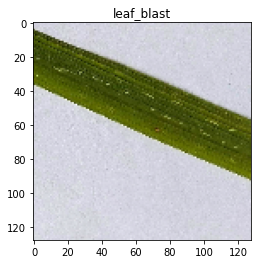

In [9]:
for image_batch, label_batch in ds.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

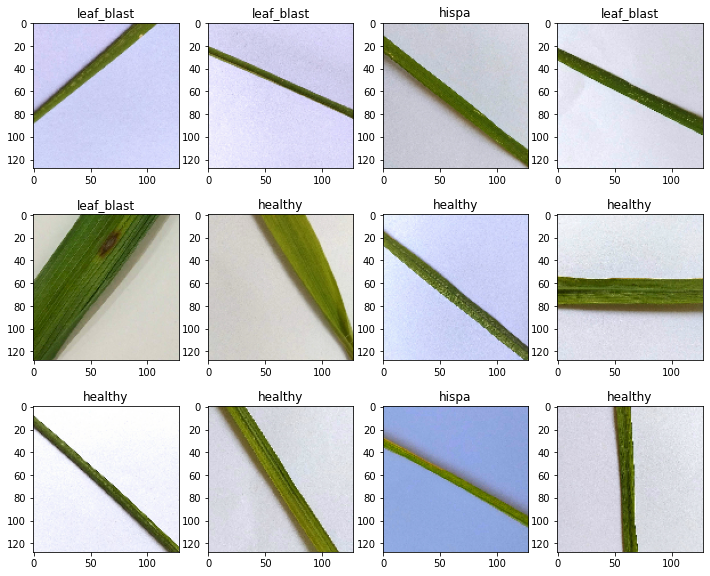

In [10]:
plt.figure(figsize=(12,10))
for image_batch, label_batch in ds.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [11]:
train_size = 0.8
validation_size = 0.1
test_size = 0.1

In [12]:
train_ds = ds.take(int(len(ds)*train_size))
len(train_ds)

168

In [13]:
valid_plus_test_ds = ds.skip(int(len(ds)*train_size))
len(valid_plus_test_ds)

42

In [14]:
valid_ds = valid_plus_test_ds.take(int(len(ds)*validation_size))
len(valid_ds)

21

In [15]:
test_ds = valid_plus_test_ds.skip(int(len(ds)*validation_size))
len(test_ds)

21

In [16]:
def train_valid_test(dataset, train_size = 0.750, validation_size = 0.125, test_size = 0.125,shuffle=True, shuffle_size=10000):
    ds_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=0)
    train_ds = dataset.take(int(ds_size*train_size))
    valid_plus_test_ds = dataset.skip(int(ds_size*train_size))
    valid_ds = valid_plus_test_ds.take(int(ds_size*validation_size))
    test_ds = valid_plus_test_ds.skip(int(ds_size*validation_size))
    return train_ds, valid_ds, test_ds

In [17]:
train_ds, valid_ds, test_ds = train_valid_test(dataset=ds)

In [18]:
len(train_ds)

157

In [19]:
len(valid_ds)

26

In [20]:
len(test_ds)

27

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2,0.5)
])

In [36]:
tf.keras.backend.clear_session()
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL_SIZE)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(4, activation="softmax")#softmax is used for multi-class classification because some of probabilty is 1.
])

In [37]:
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL_SIZE))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (16, 126, 126, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (16, 63, 63, 256)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 61, 61, 128)         295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 30, 30, 128)        0         
 2D)                                                    

In [39]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [40]:
history = model.fit(train_ds, 
                    epochs=20, 
                    batch_size=BATCH_SIZE,
                    validation_data=valid_ds)

Epoch 1/20
157/157 [==============================] - 15s 94ms/step - loss: 1.3224 - accuracy: 0.4372 - val_loss: 1.2994 - val_accuracy: 0.4159
Epoch 2/20
157/157 [==============================] - 15s 93ms/step - loss: 1.2681 - accuracy: 0.4444 - val_loss: 1.2321 - val_accuracy: 0.4423
Epoch 3/20
157/157 [==============================] - 15s 93ms/step - loss: 1.2186 - accuracy: 0.4751 - val_loss: 1.1736 - val_accuracy: 0.4904
Epoch 4/20
157/157 [==============================] - 14s 92ms/step - loss: 1.1865 - accuracy: 0.4874 - val_loss: 1.1648 - val_accuracy: 0.4976
Epoch 5/20
157/157 [==============================] - 14s 92ms/step - loss: 1.1648 - accuracy: 0.4966 - val_loss: 1.1348 - val_accuracy: 0.5000
Epoch 6/20
157/157 [==============================] - 14s 92ms/step - loss: 1.1806 - accuracy: 0.4990 - val_loss: 1.1543 - val_accuracy: 0.5168
Epoch 7/20
157/157 [==============================] - 14s 92ms/step - loss: 1.1591 - accuracy: 0.5066 - val_loss: 1.1287 - val_accuracy:

In [41]:
scores = model.evaluate(test_ds)

27/27 [==============================] - 1s 29ms/step - loss: 1.0605 - accuracy: 0.5463


In [42]:
scores

[1.0604779720306396, 0.5462962985038757]

In [43]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 157}

In [45]:
history.params["epochs"]

20

In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
history.history["accuracy"]

[0.4371758997440338,
 0.4443558156490326,
 0.4750697910785675,
 0.4874351918697357,
 0.49660947918891907,
 0.4990027844905853,
 0.5065815448760986,
 0.5117670297622681,
 0.5001994371414185,
 0.5121659636497498,
 0.5157558917999268,
 0.5221379995346069,
 0.5057837963104248,
 0.5213402509689331,
 0.531711220741272,
 0.5165536403656006,
 0.531711220741272,
 0.5360988974571228,
 0.5329078435897827,
 0.5261268615722656]

In [48]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

EPOCHS = history.params["epochs"]

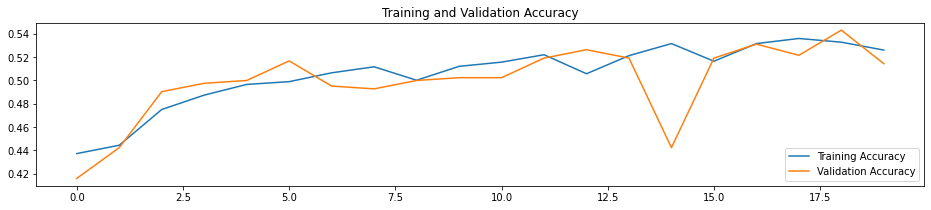

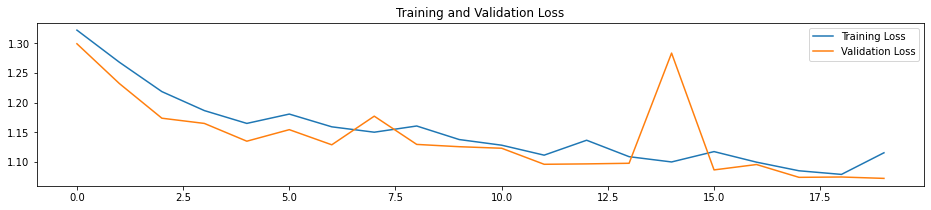

In [49]:
plt.figure(figsize=(35,3))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")
# plt.show()

plt.figure(figsize=(35,3))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")
plt.show()

First image to predict----
First image's actual label: leaf_blast

Predition of Model
[0.27370444 0.27184394 0.10355292 0.35089868]
3
First image's predicted label: leaf_blast


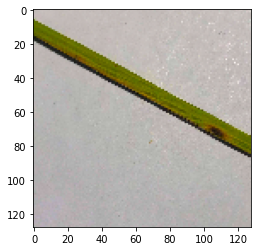

In [50]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0]
    
    print("First image to predict----")
    plt.imshow(first_image)
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("\nPredition of Model")
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
    print("First image's predicted label:",class_names[np.argmax(batch_prediction[0])])

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

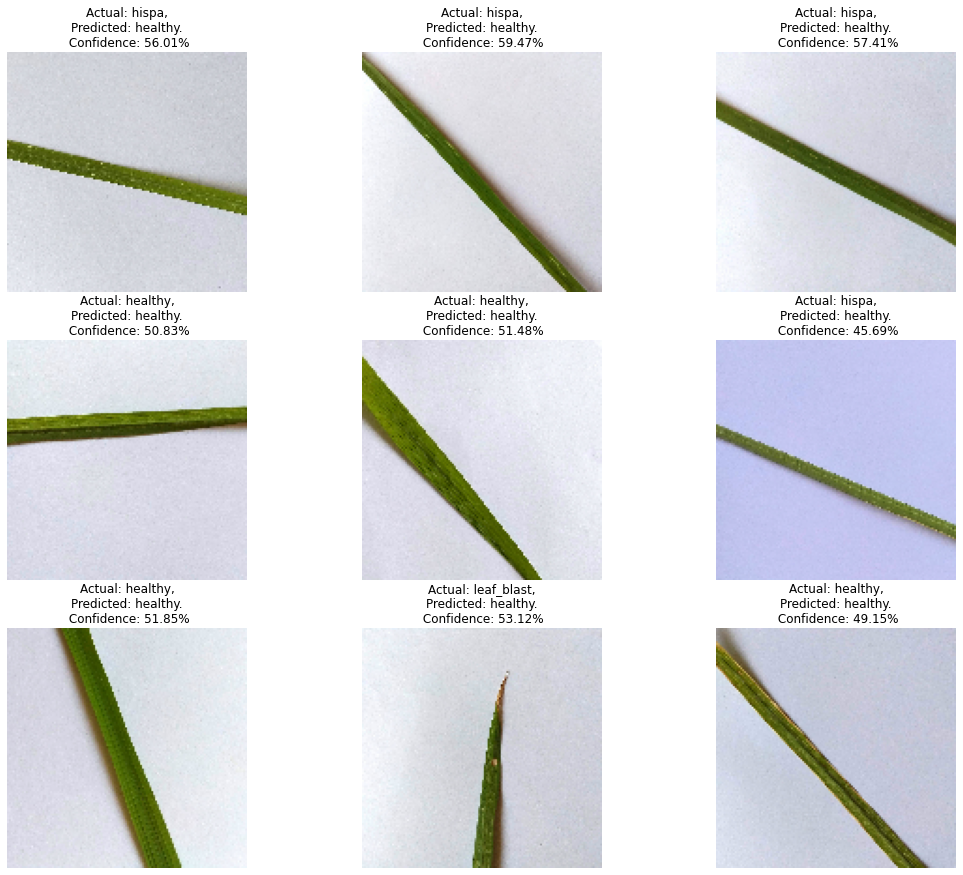

In [52]:
plt.figure(figsize=(18,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off") 

In [53]:
model_version="version_1"
model.save(f"saved_models/{model_version}", save_format="h5")